In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Definición del vector de la derivada temporal

Para este problema se utiliza el **método de líneas**, que consiste en discretizar espacialmente las ecuaciones diferenciales parciales (EDPs) para convertirlas en un sistema de ecuaciones diferenciales ordinarias (EDOs). 

La formulación matemática del sistema se expresa como:

$$\frac{d\vec{u}}{dt} = A\vec{u} + \vec{b}$$

donde:
- $\vec{u}$ es el vector de concentraciones en todos los nodos espaciales
- $A$ es la **matriz de coeficientes de transporte** que contiene los términos de:
  - Difusión
  - Convección 
  - Migración electroquímica
- $\vec{b}$ es el **vector de términos fuente** debido a la cinética electroquímica (Butler-Volmer)

La matriz $A$ es **tridiagonal** porque cada nodo de la diagonal solo depende de sus nodos vecinos.

Para este caso, la ecuación gobernante es:
\begin{equation*}
    \frac{\partial}{\partial t}(\varepsilon c_j) +\nabla N_j = \zeta_j 
\end{equation*}

Siendo $N_j$ el flux de especies según la ecuación de Nernst-Planck
\begin{equation*}
    N_j = -D_j^{eff}\nabla c_j -z_ju_jc_jF\nabla \Phi_e +vc_j 
\end{equation*}

Que al discretizarse queda:
$$\begin{align}
A_{i,i-1} &= \frac{1}{\varepsilon}\left(\frac{D}{\Delta x^2} - \frac{v}{2\Delta x} + \frac{z \mu F \nabla\Phi}{2\Delta x}\right) \\
A_{i,i} &= \frac{-2D}{\varepsilon \Delta x^2} \\
A_{i,i+1} &= \frac{1}{\varepsilon}\left(\frac{D}{\Delta x^2} + \frac{v}{2\Delta x} - \frac{z \mu F \nabla\Phi}{2\Delta x}\right) \\
b_i &= \frac{\pm a i_0 \eta_s}{\varepsilon RT}
\end{align}$$

Con condiciones de borde:
\begin{equation*}
\text{CB1 :} \quad C (x=0)= C_{in}
\end{equation*}

\begin{equation*}
\text{CB2 :} \quad \frac{\partial}{\partial x}C_j (x=L)=0
\end{equation*}

Y condición inicial:
\begin{equation*}
\text{CI :} \quad C (t=0)= C_{0}
\end{equation*}

1. Definición de valores del enunciado

In [2]:
# Datos enunciado
R    = 8.314  # Constante de los gases [J/(mol·K)]
T   = 298.15 # Temperatura [K]
F   = 96485  # Constante de Faraday [C/mol]
gradPot = 10 # Gradiente de potencial [V/m]
C_in_V2 = 950  # Concentración de entrada de V2+ [mol/m3]
C_in_V3 = 50
porosidad = 0.88 # Porosidad del electrodo
# Cinética de reacción
i0 = 1000      # Densidad de corriente de intercambio [A/m2]
eta_s = 0.01  # Sobrepotencial [V]
a = 3e4      # Área específica del electrodo [m2/m3]
# Velocidad
v     = 10e-6  # Velocidad del anolito [m/s]
# Difusividades
D = 1e-9      # Difusividad efectiva [m2/s]
mu = D / (R*T)
# Longitud del dominio
thickness = 0.0004  # Espesor del electrodo [m]

2. Definición de función du/dt

In [3]:

def dudt(t, u):
    """ 
    du/dt = A*u + b
    Ecuación de transporte para las dos especies de la celda.
    """
    N_A = 100                # Número de nodos
    N             = N_A
    dx      = thickness/(N_A-1)    # Longitud entre cada nodo [m]
    
    # Concentraciones
    u_V2   = u[:N]      # V+2 
    u_V3   = u[N:2*N]   # V+3 

    #Vector derivada temporal dc/dt
    dcdt = np.zeros(2*N)

    # ─────────────────────────────────────────────────────────────────────
    # V²⁺ TRANSPORT MATRIX 
    # ─────────────────────────────────────────────────────────────────────
    z = +2  # Numero de carga del V+2
    A = np.zeros((len(u_V2), len(u_V2))) #Definición de la matriz
    b = np.zeros(len(u_V2))              #Termino de fuente

    for i in range(1,len(u_V2)-1):
        A[i,i-1] = (D/dx**2 -v/(2*dx) + z * mu * F * gradPot /(2*dx))/porosidad
        A[i,i] =  (-2*D/dx**2)/porosidad
        A[i,i+1] = (D/dx**2 + v/(2*dx) - z * mu * F * gradPot /(2*dx))/porosidad
        b[i] = -a * i0 * eta_s / (R*T) / porosidad



    # CB1: Concentración constante en el lado del CC
    A[0,0]  = 0
    A[0,1]  = 0
    b[0]    = 0
    
    # Vector dudt
    dcdt[0:N] = np.dot(A, u_V2) + b

    # CB2: Gradiente de concentración nulo
    dcdt[N-1] = 4/3 * dcdt[N-2] -1/3 * dcdt[N-3]



    # ─────────────────────────────────────────────────────────────────────
    # V3⁺ TRANSPORT MATRIX 
    # ─────────────────────────────────────────────────────────────────────
    z = +3  # Numero de carga del V3+
    A = np.zeros((len(u_V2), len(u_V2))) #Definición de la matriz
    b = np.zeros(len(u_V2))              #Termino de fuente
    for i in range(1,len(u_V2)-1):
        A[i,i-1] = (D/dx**2 -v/(2*dx) + z * mu * F * gradPot /(2*dx))/porosidad
        A[i,i] =  (-2*D/dx**2)/porosidad
        A[i,i+1] = (D/dx**2 + v/(2*dx) - z * mu * F * gradPot /(2*dx))/porosidad
        b[i] = +a * i0 * eta_s / (R*T) / porosidad


    # CB1: Concentración constante en el lado del CC
    A[0,0]  = 0
    A[0,1]  = 0
    b[0]    = 0

    
    # Vector dudt
    dcdt[N:2*N] = np.dot(A, u_V3) + b

    # CB2: Gradiente de concentración nulo
    dcdt[-1] = 4/3 * dcdt[-2] -1/3 * dcdt[-3]
    return dcdt
    

## Método de líneas con solve_ivp

In [4]:
N = 100
#Definición del vector de condiciones iniciales
c0 = np.ones(2*N)
#Concentración inicial del Vanadio+2
c0[:N] = C_in_V2
#Concentración inicial del Vanadio+3
c0[N:2*N] = C_in_V3
#Tiempo de integración
t_span = (0,5)
#Tiempo en que se evalua la función al entregar la solución (opcional)
t_eval = [0, 2.5, 5]  # tiempo inicial, mitad, y final


#Solución del sistema de EDOs con método de líneas
c = solve_ivp(dudt, t_span, c0, t_eval=t_eval)

## Gráfico de la solución a distintos tiempos

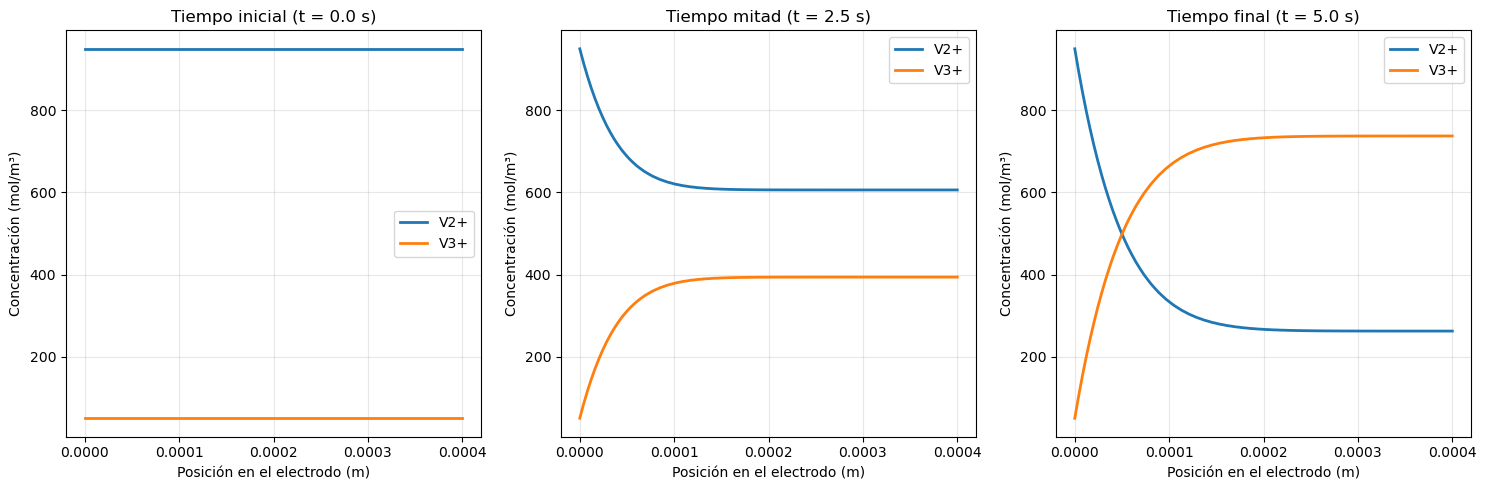

In [5]:
x_grilla = np.linspace(0, thickness, N)

# Crear figura con 3 subgráficos
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Tiempo inicial (t = 0)
axes[0].plot(x_grilla, c.y[:N,0], label='V2+', linewidth=2)
axes[0].plot(x_grilla, c.y[N:2*N,0], label='V3+', linewidth=2)
axes[0].set_xlabel('Posición en el electrodo (m)')
axes[0].set_ylabel('Concentración (mol/m³)')
axes[0].set_title(f'Tiempo inicial (t = {c.t[0]:.1f} s)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Tiempo mitad (t = 2.5)
axes[1].plot(x_grilla, c.y[:N,1], label='V2+', linewidth=2)
axes[1].plot(x_grilla, c.y[N:2*N,1], label='V3+', linewidth=2)
axes[1].set_xlabel('Posición en el electrodo (m)')
axes[1].set_ylabel('Concentración (mol/m³)')
axes[1].set_title(f'Tiempo mitad (t = {c.t[1]:.1f} s)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Tiempo final (t = 5.0)
axes[2].plot(x_grilla, c.y[:N,2], label='V2+', linewidth=2)
axes[2].plot(x_grilla, c.y[N:2*N,2], label='V3+', linewidth=2)
axes[2].set_xlabel('Posición en el electrodo (m)')
axes[2].set_ylabel('Concentración (mol/m³)')
axes[2].set_title(f'Tiempo final (t = {c.t[2]:.1f} s)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Aplicar menos graduaciones a todos los subplots
for ax in axes:
    ax.set_xticks(np.linspace(0, thickness, 5))  # 5 graduaciones en cada subplot

plt.tight_layout()
plt.show()